## Importing and stuff

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=e705c763cfee7bf9be743debb0656792948f1b676731bd65bf4f4ac71529d284
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, auc, roc_curve,confusion_matrix

import os

import sys

import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import shap
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.decomposition import PCA


In [ ]:
sys.path.insert(0,"/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester")

In [ ]:
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"
models_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/"

In [ ]:
# Random Forest Classifier Class
import RFClassifier
from RFClassifier import RFClassifier

In [ ]:
# Data Class
import DataClass 
from DataClass import Data
# read prepared data
data = Data( 0, "", "",parquet_path)

In [ ]:
data.scaled_stances_statics_df=data.scaled_stances_statics_df.rename({'L4_kurtosis':'L4_Kurtosis','L5_kurtosis':'L5_Kurtosis'},axis=1)

## Get the data

In [ ]:
cols = np.append(data.cols_names[1:17] , ['r', 'l'])
cols

array(['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'R1', 'R2', 'R3',
       'R4', 'R5', 'R6', 'R7', 'R8', 'r', 'l'], dtype='<U2')

In [ ]:
signal_cols = []
for col in cols:
  colname = col +'_interp'
  signal_cols.append(colname)
for col in data.cols_names[1:]:
  colname = col +'_Min'
  signal_cols.append(colname)


In [ ]:
signal_cols= np.append( signal_cols, ['ID','y','level'])
signal_cols

array(['L1_interp', 'L2_interp', 'L3_interp', 'L4_interp', 'L5_interp',
       'L6_interp', 'L7_interp', 'L8_interp', 'R1_interp', 'R2_interp',
       'R3_interp', 'R4_interp', 'R5_interp', 'R6_interp', 'R7_interp',
       'R8_interp', 'r_interp', 'l_interp', 'L1_Min', 'L2_Min', 'L3_Min',
       'L4_Min', 'L5_Min', 'L6_Min', 'L7_Min', 'L8_Min', 'R1_Min',
       'R2_Min', 'R3_Min', 'R4_Min', 'R5_Min', 'R6_Min', 'R7_Min',
       'R8_Min', 'Total_Force_Left_Min', 'Total_Force_Right_Min', 'ID',
       'y', 'level'], dtype='<U21')

### Split into train and test

In [ ]:
df = data.scaled_stances_statics_df.drop(signal_cols,axis=1)
y = data.scaled_stances_statics_df[[ 'y']]

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

In [ ]:
y = data.scaled_stances_statics_df[[ 'level']]


y['level'].replace(3, 4, inplace= True)
     

y['level'].replace(2.5, 3, inplace= True)
     

y_m=y['level'].astype('int')
     

# splitting the data
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(df, y_m, random_state=42)

<ipython-input-12-94402a8ade58>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['level'].replace(3, 4, inplace= True)
<ipython-input-12-94402a8ade58>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['level'].replace(2.5, 3, inplace= True)


## RFC (statics with 6 features) then Interpretation

In [ ]:
# Checking which RFC will work the best
rfc = RFClassifier(models_path,100,2)
# ccs=rfc.multiple_training([5, 10, 20, 40, 100, 200],2, X_train, y_train, X_test,  y_test )
rfc.taining( X_train, y_train)
y_pred=rfc.predict(X_test)
scores=rfc.scores(y_test, y_pred)

In [ ]:
rfc.print_scores(scores[0],scores[1],scores[2],scores[3])

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


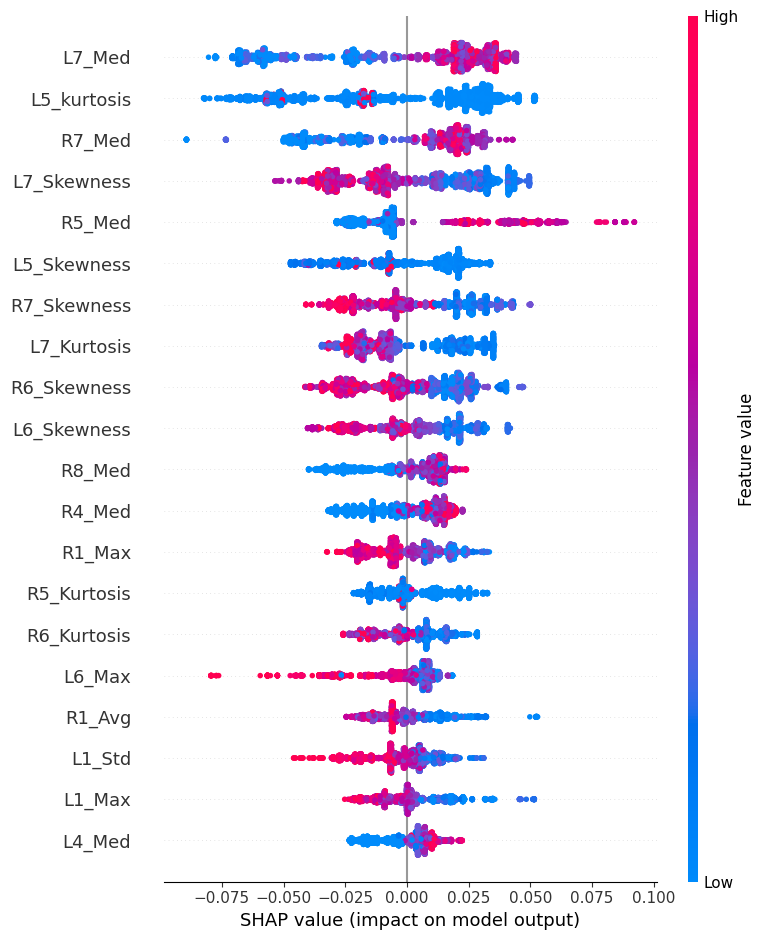

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfc.rf_classifier)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)

In [ ]:
rfc = RFClassifier(models_path,100,2)
# ccs=rfc.multiple_training([5, 10, 20, 40, 100, 200],2, X_train, y_train, X_test,  y_test )
rfc.taining( X_train, y_train)
perm = PermutationImportance(rfc.rf_classifier, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,L6_Avg
0 ± 0.0000,L2_Med
0 ± 0.0000,L2_Avg
0 ± 0.0000,L2_Skewness
0 ± 0.0000,L2_Kurtosis
0 ± 0.0000,L3_Max
0 ± 0.0000,L3_Std
0 ± 0.0000,L3_Med
0 ± 0.0000,L3_Avg
0 ± 0.0000,L3_Skewness


## RFC (6 features) then Interpretation

In [ ]:
for col in data.scaled_stances_statics_df.columns:
  print(col)

In [ ]:
statics=[]
for col in data.cols_names[1:]:
  for x in ['_Min', '_Std', '_Med','_Avg','_Skewness','_Kurtosis']:
    statics.append((col+''+x))

signal_cols= np.append( signal_cols, statics)

In [ ]:
df = data.scaled_stances_statics_df.drop(signal_cols,axis=1)
y = data.scaled_stances_statics_df[[ 'y']]

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

In [ ]:
# Checking which RFC will work the best
rfc = RFClassifier(models_path,200,2)
ccs=rfc.multiple_training([5, 10, 20, 40, 100, 200],2, X_train, y_train, X_test,  y_test )

Estimator = 5
Accuracy: 0.9386, Precision: 0.9383, Recall: 0.9735, F1: 0.9556
Estimator = 10
Accuracy: 0.9544, Precision: 0.9546, Recall: 0.9793, F1: 0.9668
Estimator = 20
Accuracy: 0.9603, Precision: 0.9541, Recall: 0.9890, F1: 0.9713
Estimator = 40
Accuracy: 0.9612, Precision: 0.9531, Recall: 0.9916, F1: 0.9720
Estimator = 100
Accuracy: 0.9627, Precision: 0.9540, Recall: 0.9929, F1: 0.9731
Estimator = 200
Accuracy: 0.9638, Precision: 0.9547, Recall: 0.9939, F1: 0.9739


In [ ]:
perm = PermutationImportance(ccs[5], random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=30)

Weight,Feature
0.0318 ± 0.0039,l_peaks_heel
0.0243 ± 0.0050,r_peaks_heel
0.0156 ± 0.0020,L6_fwhm
0.0135 ± 0.0022,l_max_peak
0.0115 ± 0.0030,r_swings_time
0.0099 ± 0.0018,R6_fwhm
0.0094 ± 0.0023,L5_fwhm
0.0086 ± 0.0024,l_swings_time
0.0051 ± 0.0013,l_peaks_toe
0.0048 ± 0.0018,R5_fwhm


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


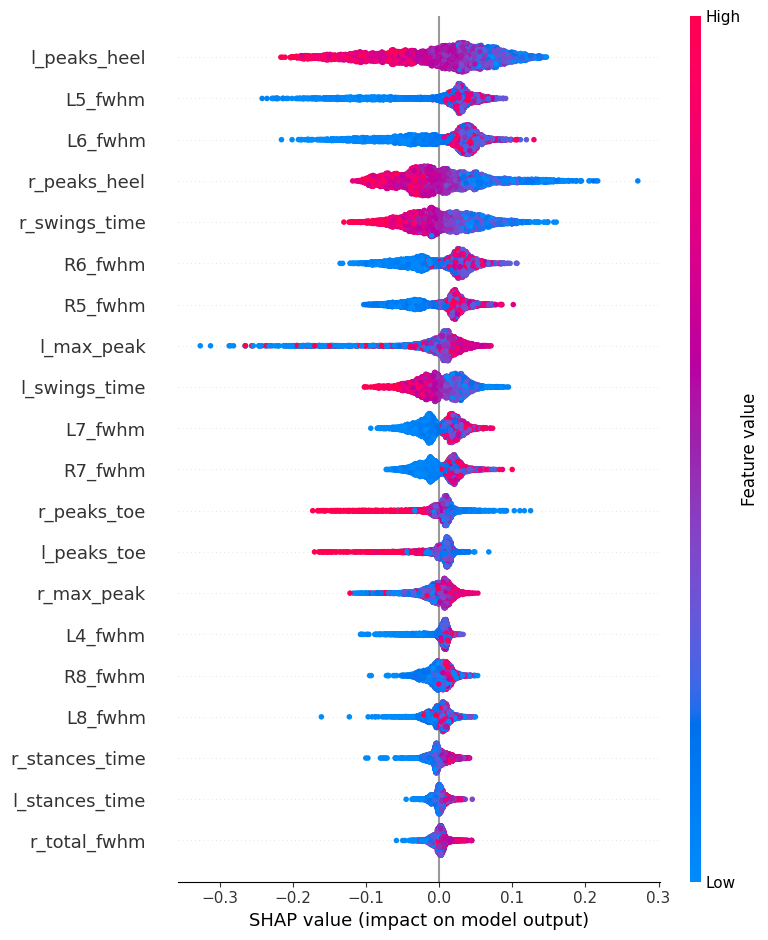

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(ccs[5])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)

In [ ]:
(X_test.columns)

Index(['l_strides_time', 'l_swings_time', 'l_stances_time', 'l_peaks_heel',
       'l_peaks_toe', 'r_strides_time', 'r_swings_time', 'r_stances_time',
       'r_peaks_heel', 'r_peaks_toe', 'l_max_peak', 'r_max_peak',
       'l_total_fwhm', 'r_total_fwhm', 'L1_fwhm', 'L2_fwhm', 'L3_fwhm',
       'L4_fwhm', 'L5_fwhm', 'L6_fwhm', 'L7_fwhm', 'L8_fwhm', 'R1_fwhm',
       'R2_fwhm', 'R3_fwhm', 'R4_fwhm', 'R5_fwhm', 'R6_fwhm', 'R7_fwhm',
       'R8_fwhm'],
      dtype='object')

## RFC Multiclass classification (statics with extracted features) then Interpretation


In [ ]:
for col in X_train_m.columns:
  print(col)

In [ ]:
# Checking which RFC will work the best
rfc_m = RFClassifier(models_path,200,2,'micro')
ccs=rfc_m.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_m, y_train_m, X_test_m,  y_test_m )

Estimator = 5
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 10
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 20
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 40
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 100
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 200
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [ ]:
perm = PermutationImportance(ccs[0], random_state=1).fit(X_test_m, y_test_m)
eli5.show_weights(perm, feature_names = X_test_m.columns.tolist())

Weight,Feature
0.0452 ± 0.0042,L7_Med
0.0196 ± 0.0023,R5_Med
0.0087 ± 0.0027,L6_Skewness
0.0029 ± 0.0012,R6_Kurtosis
0.0011 ± 0.0003,L8_Med
0.0011 ± 0.0006,R4_Skewness
0.0006 ± 0.0004,L5_Max
0.0005 ± 0.0006,R3_Skewness
0 ± 0.0000,L3_Avg
0 ± 0.0000,L3_Med


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


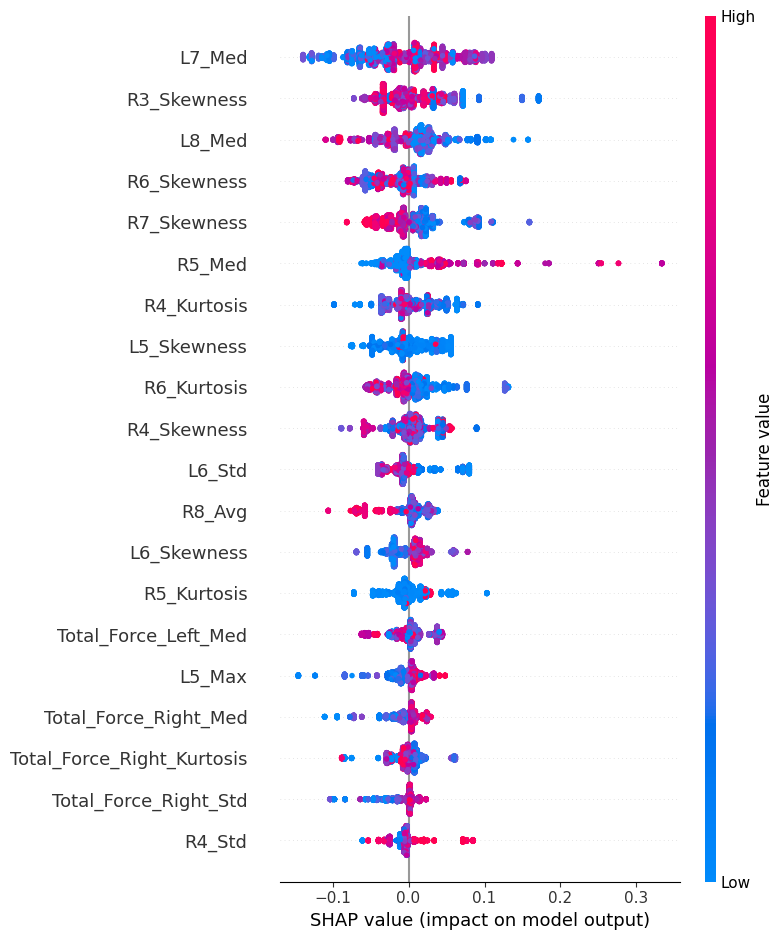

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(ccs[0])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_m)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test_m)

## RFC Multiclass classification with extracted features

In [ ]:
statics=[]
for col in data.cols_names[1:]:
  for x in ['_Min', '_Std', '_Med','_Avg','_Skewness','_Kurtosis']:
    statics.append((col+''+x))

signal_cols= np.append( signal_cols, statics)

In [ ]:
df = data.scaled_stances_statics_df.drop(signal_cols,axis=1)
y = data.scaled_stances_statics_df[[ 'level']]

y['level'].replace(3, 4, inplace= True)
     

y['level'].replace(2.5, 3, inplace= True)
     

y_m=y['level'].astype('int')
     


# splitting the data
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
for col in df.columns:
  print(col)

l_strides_time
l_swings_time
l_stances_time
l_peaks_heel
l_peaks_toe
r_strides_time
r_swings_time
r_stances_time
r_peaks_heel
r_peaks_toe
l_max_peak
r_max_peak
l_total_fwhm
r_total_fwhm
L1_fwhm
L2_fwhm
L3_fwhm
L4_fwhm
L5_fwhm
L6_fwhm
L7_fwhm
L8_fwhm
R1_fwhm
R2_fwhm
R3_fwhm
R4_fwhm
R5_fwhm
R6_fwhm
R7_fwhm
R8_fwhm


In [ ]:
# Checking which RFC will work the best
rfc_m = RFClassifier(models_path,200,2,'micro')
ccs=rfc_m.multiple_training([5, 10, 20, 40, 100, 200],2, X_train, y_train, X_test,  y_test )

Estimator = 5
Accuracy: 0.8776, Precision: 0.8776, Recall: 0.8776, F1: 0.8776
Estimator = 10
Accuracy: 0.9081, Precision: 0.9081, Recall: 0.9081, F1: 0.9081
Estimator = 20
Accuracy: 0.9206, Precision: 0.9206, Recall: 0.9206, F1: 0.9206
Estimator = 40
Accuracy: 0.9320, Precision: 0.9320, Recall: 0.9320, F1: 0.9320
Estimator = 100
Accuracy: 0.9359, Precision: 0.9359, Recall: 0.9359, F1: 0.9359
Estimator = 200
Accuracy: 0.9392, Precision: 0.9392, Recall: 0.9392, F1: 0.9392


In [ ]:
perm = PermutationImportance(ccs[5], random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=30)

Weight,Feature
0.0276 ± 0.0030,l_peaks_heel
0.0220 ± 0.0031,r_peaks_toe
0.0220 ± 0.0029,r_peaks_heel
0.0181 ± 0.0034,l_peaks_toe
0.0168 ± 0.0010,l_max_peak
0.0124 ± 0.0024,r_max_peak
0.0101 ± 0.0038,L6_fwhm
0.0092 ± 0.0015,R6_fwhm
0.0075 ± 0.0034,L5_fwhm
0.0072 ± 0.0018,r_swings_time


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


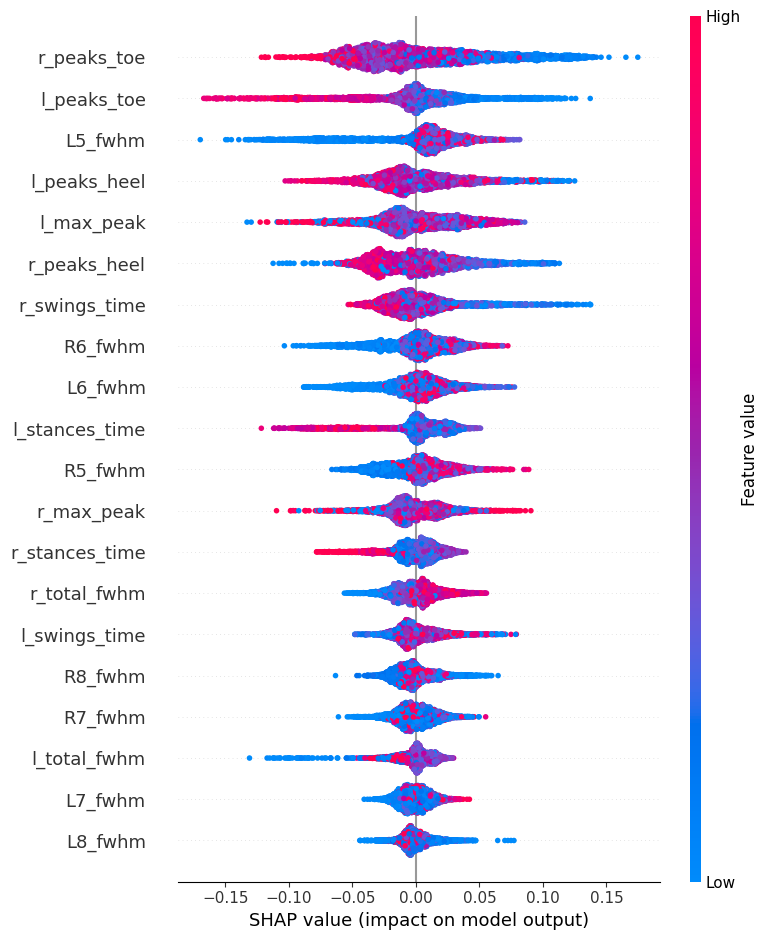

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(ccs[5])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)

## RFC Binary classification - Scaled stances wih fwhm from the forces of 16 sensor from the right & left foot and the sum of all sensors and the with 6 extra features each 

In [ ]:
colnames_9=['r_interp','l_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel','l_swings_time','l_max_peak','l_total_fwhm','l_strides_time','l_peaks_toe','l_peaks_heel']
for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp", "fwhm"]:
      colnames_9.append( col +'_' +  x)

In [ ]:
col_lists_9=[]
for col in ["l","r","L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp"]:
      col_lists_9.append( col +'_' +  x)

In [ ]:
df_9 = data.scaled_stances_statics_df[colnames_9]
y_9 = data.scaled_stances_statics_df[[ 'y']]
# reformatting
for col in col_lists_9:
  colnames_9.remove(col)
df_9 = data.return_array_df_mul_lists(df_9,col_lists_9,colnames_9)
# df_7 = np.asarray([l for l in df_7 if ~np.isnan(l).any()])
df_9[np.isnan(df_9)] = 0
# splitting the data
X_train_9, X_test_9, y_train_9, y_test_9 = train_test_split(df_9, y_9, random_state=42)

In [ ]:
# Checking which RFC will work the best
rfc_9 = RFClassifier(models_path,200,2)
ccs_9=rfc_9.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_9, y_train_9, X_test_9,  y_test_9 )

Estimator = 5
Accuracy: 0.9434, Precision: 0.9423, Recall: 0.9764, F1: 0.9590
Estimator = 10
Accuracy: 0.9596, Precision: 0.9593, Recall: 0.9822, F1: 0.9706
Estimator = 20
Accuracy: 0.9631, Precision: 0.9529, Recall: 0.9948, F1: 0.9734
Estimator = 40
Accuracy: 0.9636, Precision: 0.9530, Recall: 0.9955, F1: 0.9738
Estimator = 100
Accuracy: 0.9645, Precision: 0.9533, Recall: 0.9964, F1: 0.9744
Estimator = 200
Accuracy: 0.9642, Precision: 0.9524, Recall: 0.9971, F1: 0.9743


In [ ]:
X_test_9.shape

(4557, 1828)

In [ ]:
final_cols=[]
for col in col_lists_9:
  for i in np.arange(0,100):
    final_cols.append(col+'_'+str(i))
for col in colnames_9:
    final_cols.append(col)
len(final_cols)

1828

In [ ]:
perm = PermutationImportance(ccs_9[4], random_state=1).fit(X_test_9, y_test_9)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=30)

In [ ]:
weights = list(zip(final_cols, perm.feature_importances_)) #perm.feature_importances_ 

In [ ]:
importance=perm.feature_importances_

In [ ]:
from collections import defaultdict
temp = defaultdict(list)
for i, j in weights:
    temp[j].append(i)

In [ ]:
sort_orders = sorted(temp.items(), key=lambda x: x[0], reverse=True)

In [ ]:
features=[]
importances=[]
for i in range(len(sort_orders)):
  features.append(sort_orders[i][1])
  importances.append(sort_orders[i][0])

In [ ]:
short_labels =[]
for row in features:
  temp =''
  for i,f in enumerate(row):
    temp=temp+f+' '
    if (i ==4):
      temp=temp+'...'
      break
  short_labels.append(temp)

In [ ]:
df = pd.DataFrame({'features': short_labels, 'value':importances, 'all_features':features})

In [ ]:
df.to_parquet(parquet_path+'RFC_both_feet_16_sensors_sumsensors_6_features_importances.gzip')

In [ ]:
import plotly.express as px
fig = px.bar(df, x="features", y="value")
fig.update_layout(
    height=700,
    font=dict(
        size=10,  # Set the font size here
    )
)
fig.show()

## PCA  Binary classification (statics with extracted features) then Model then explaining

In [ ]:
# PCA
pca = PCA(n_components=10)
x = pca.fit_transform(df)
# Dump components relations with features:
# print(pd.DataFrame(pca.components_,columns=df.columns ))

In [ ]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = list(df.columns)
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}


In [ ]:
# build the dataframe
df_important = pd.DataFrame(dic.items())

In [ ]:
df_important 

,0,1
0,PC0,Total_Force_Left_Max
1,PC1,R5_Kurtosis
2,PC2,R1_Max
3,PC3,L8_Max
4,PC4,R4_Max
5,PC5,R7_Max
6,PC6,R7_Max
7,PC7,Total_Force_Right_Max
8,PC8,L2_Max
9,PC9,L3_Max


In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(x, y, random_state=42)

In [ ]:
# Train a Random Forest Classifier
rfc_pca = RFClassifier(models_path,100,2)
ccs_pca=rfc_pca.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_pca, y_train_pca, X_test_pca,  y_test_pca)

Estimator = 5
Accuracy: 0.9978, Precision: 0.9977, Recall: 0.9990, F1: 0.9984
Estimator = 10
Accuracy: 0.9982, Precision: 0.9994, Recall: 0.9981, F1: 0.9987
Estimator = 20
Accuracy: 0.9982, Precision: 0.9990, Recall: 0.9984, F1: 0.9987
Estimator = 40
Accuracy: 0.9989, Precision: 0.9994, Recall: 0.9990, F1: 0.9992
Estimator = 100
Accuracy: 0.9991, Precision: 0.9994, Recall: 0.9994, F1: 0.9994
Estimator = 200
Accuracy: 0.9989, Precision: 0.9994, Recall: 0.9990, F1: 0.9992


In [ ]:
perm = PermutationImportance(ccs_pca[4], random_state=1).fit(X_test_pca, y_test_pca)
eli5.show_weights(perm,  top=10)

Weight,Feature
0.1938 ± 0.0040,x3
0.0729 ± 0.0067,x4
0.0421 ± 0.0033,x2
0.0346 ± 0.0012,x1
0.0146 ± 0.0013,x0
0.0061 ± 0.0016,x5
0.0031 ± 0.0013,x9
0.0029 ± 0.0009,x8
0.0023 ± 0.0011,x6
0.0010 ± 0.0004,x7


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


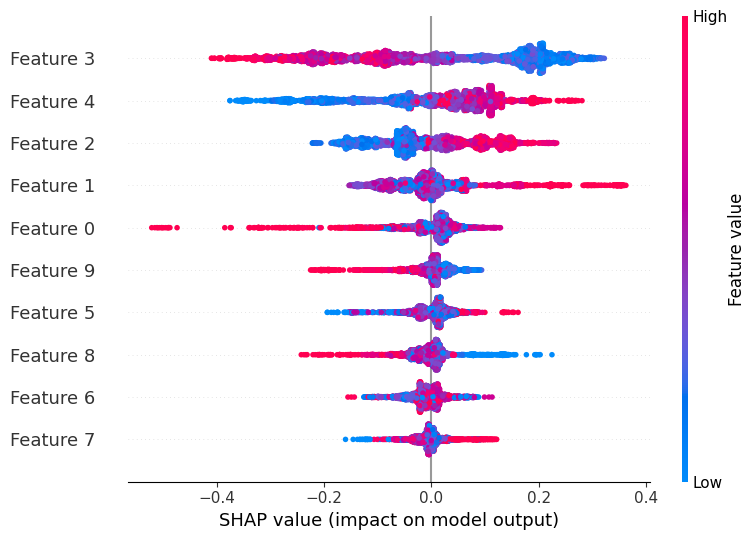

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(ccs_pca[4])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_pca)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test_pca)

## PCA  Binary classification (extracted features without statics) then Model then explaining

In [ ]:
statics=[]
for col in data.cols_names[1:]:
  for x in ['_Max','_Min', '_Std', '_Med','_Avg','_Skewness','_Kurtosis']:
    statics.append((col+''+x))

signal_cols= np.append( signal_cols, statics)

In [ ]:
df = data.scaled_stances_statics_df.drop(signal_cols,axis=1)
y = data.scaled_stances_statics_df[[ 'y']]


In [ ]:
# PCA
pca = PCA(n_components=10)
x = pca.fit_transform(df)
# Dump components relations with features:
# print(pd.DataFrame(pca.components_,columns=df.columns ))
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = list(df.columns)
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
# build the dataframe
df_important = pd.DataFrame(dic.items())
df_important

,0,1
0,PC0,r_max_peak
1,PC1,r_peaks_heel
2,PC2,l_peaks_toe
3,PC3,l_max_peak
4,PC4,l_peaks_heel
5,PC5,r_peaks_toe
6,PC6,R1_fwhm
7,PC7,L6_fwhm
8,PC8,L1_fwhm
9,PC9,R1_fwhm


In [ ]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
# Train a Random Forest Classifier
rfc_pca = RFClassifier(models_path,100,2)
ccs_pca=rfc_pca.multiple_training([5, 10, 20, 40, 100, 200],2, X_train, y_train, X_test,  y_test)

Estimator = 5
Accuracy: 0.9263, Precision: 0.9323, Recall: 0.9612, F1: 0.9465
Estimator = 10
Accuracy: 0.9368, Precision: 0.9434, Recall: 0.9648, F1: 0.9540
Estimator = 20
Accuracy: 0.9429, Precision: 0.9417, Recall: 0.9764, F1: 0.9587
Estimator = 40
Accuracy: 0.9443, Precision: 0.9396, Recall: 0.9809, F1: 0.9598
Estimator = 100
Accuracy: 0.9467, Precision: 0.9404, Recall: 0.9838, F1: 0.9616
Estimator = 200
Accuracy: 0.9469, Precision: 0.9390, Recall: 0.9858, F1: 0.9618


In [ ]:
perm = PermutationImportance(ccs_pca[5], random_state=1).fit(X_test, y_test)
eli5.show_weights(perm,  top=10)

Weight,Feature
0.1846 ± 0.0125,x1
0.1092 ± 0.0064,x2
0.0660 ± 0.0058,x0
0.0443 ± 0.0028,x5
0.0367 ± 0.0040,x4
0.0348 ± 0.0035,x8
0.0294 ± 0.0034,x6
0.0122 ± 0.0028,x7
0.0100 ± 0.0042,x3
0.0084 ± 0.0030,x9


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


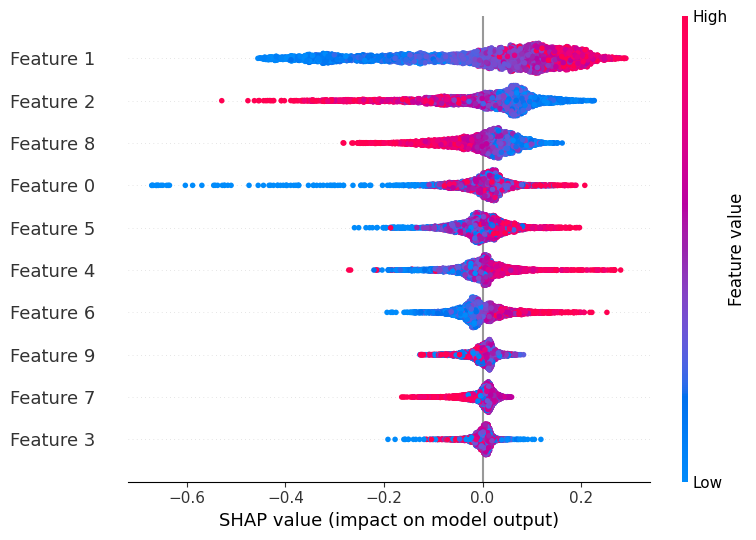

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(ccs_pca[5])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)

## Feature Selections  Binary classification (extracted features with statics) then Model then explaining

In [ ]:
df.shape

(18226, 138)

In [ ]:
# select the top 15 features based on mutual information score
selector = SelectKBest(mutual_info_classif, k=15)
X_train_selected = selector.fit_transform(X_train, np.ravel(y_train))
X_val_selected = selector.transform(X_test)

In [ ]:
# Train a Random Forest Classifier
model = RFClassifier(models_path,100,2)
ccs=rfc_pca.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_selected, y_train, X_val_selected,  y_test)

Estimator = 5
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 10
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 20
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 40
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 100
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 200
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [ ]:
len(X_train_selected[0])

15

In [ ]:
# print the names of the selected features
selected_features = [df.columns[i] for i in selector.get_support(indices=True)]
print("Selected features:", selected_features)

Selected features: ['L1_Std', 'L2_Avg', 'L3_Skewness', 'L3_Kurtosis', 'L7_Std', 'L7_Avg', 'R1_Avg', 'R2_Std', 'R2_Avg', 'R7_Kurtosis', 'R8_Skewness', 'R8_Kurtosis', 'Total_Force_Left_Std', 'Total_Force_Right_Max', 'Total_Force_Right_Std']


In [ ]:
perm = PermutationImportance(ccs[0], random_state=1).fit(X_val_selected, y_test)
eli5.show_weights(perm, feature_names = selected_features, top=15)

Weight,Feature
0.0821 ± 0.0029,R1_Avg
0.0704 ± 0.0037,L7_Avg
0.0496 ± 0.0033,R7_Kurtosis
0.0486 ± 0.0023,R8_Skewness
0.0175 ± 0.0016,L1_Std
0.0158 ± 0.0026,L7_Std
0.0043 ± 0.0011,L3_Kurtosis
0.0039 ± 0.0016,L2_Avg
0.0020 ± 0.0004,Total_Force_Right_Max
0.0018 ± 0.0010,R2_Avg


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


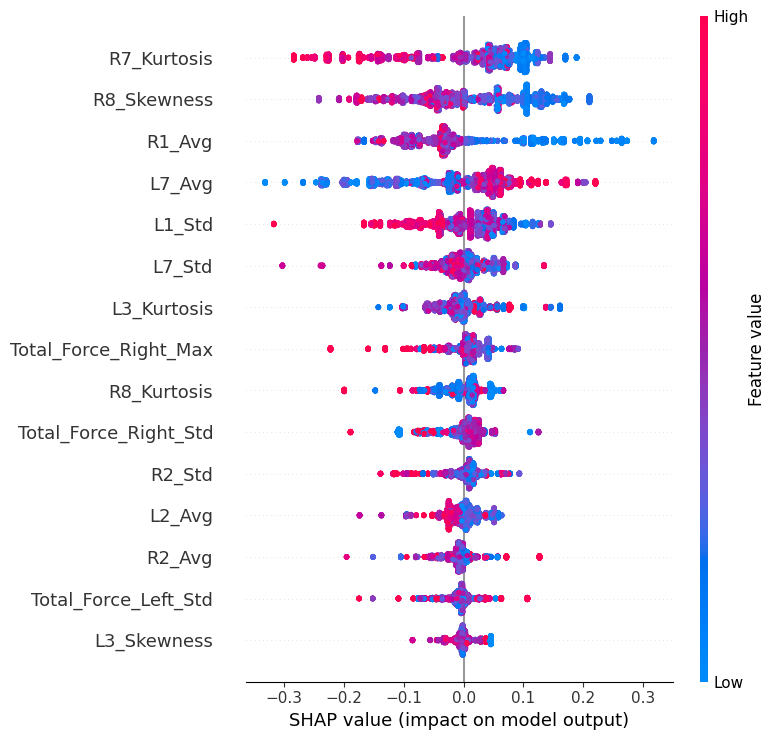

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(ccs[0])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_val_selected)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_val_selected,feature_names=selected_features)

## Feature Selection  Binary classification (extracted features without statics) then Model then explaining

In [ ]:
df.shape

(18226, 30)

In [ ]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

In [ ]:
X_train.shape

(13669, 30)

In [ ]:
# select the top 20 features based on mutual information score
selector = SelectKBest(mutual_info_classif, k=15)
X_train_selected = selector.fit_transform(X_train, np.ravel(y_train))
X_val_selected = selector.transform(X_test)

In [ ]:
# Train a Random Forest Classifier
model = RFClassifier(models_path,100,2)
ccs=rfc_pca.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_selected, y_train, X_val_selected,  y_test)

Estimator = 5
Accuracy: 0.9228, Precision: 0.9247, Recall: 0.9648, F1: 0.9443
Estimator = 10
Accuracy: 0.9364, Precision: 0.9378, Recall: 0.9706, F1: 0.9539
Estimator = 20
Accuracy: 0.9465, Precision: 0.9395, Recall: 0.9845, F1: 0.9615
Estimator = 40
Accuracy: 0.9480, Precision: 0.9394, Recall: 0.9871, F1: 0.9626
Estimator = 100
Accuracy: 0.9471, Precision: 0.9390, Recall: 0.9861, F1: 0.9620
Estimator = 200
Accuracy: 0.9473, Precision: 0.9380, Recall: 0.9877, F1: 0.9622


In [ ]:
len(X_train_selected[0])

15

In [ ]:
# print the names of the selected features
selected_features = [df.columns[i] for i in selector.get_support(indices=True)]
print("Selected features:", selected_features)

Selected features: ['l_peaks_heel', 'l_peaks_toe', 'r_peaks_heel', 'r_peaks_toe', 'l_total_fwhm', 'L4_fwhm', 'L5_fwhm', 'L6_fwhm', 'L7_fwhm', 'L8_fwhm', 'R1_fwhm', 'R5_fwhm', 'R6_fwhm', 'R7_fwhm', 'R8_fwhm']


In [ ]:
perm = PermutationImportance(ccs[3], random_state=1).fit(X_val_selected, y_test)
eli5.show_weights(perm, feature_names = selected_features, top=15)

Weight,Feature
0.0528 ± 0.0037,l_peaks_heel
0.0513 ± 0.0059,r_peaks_heel
0.0305 ± 0.0023,L5_fwhm
0.0266 ± 0.0025,L6_fwhm
0.0254 ± 0.0053,R6_fwhm
0.0170 ± 0.0029,R8_fwhm
0.0162 ± 0.0039,R7_fwhm
0.0162 ± 0.0024,r_peaks_toe
0.0146 ± 0.0029,l_peaks_toe
0.0136 ± 0.0018,l_total_fwhm


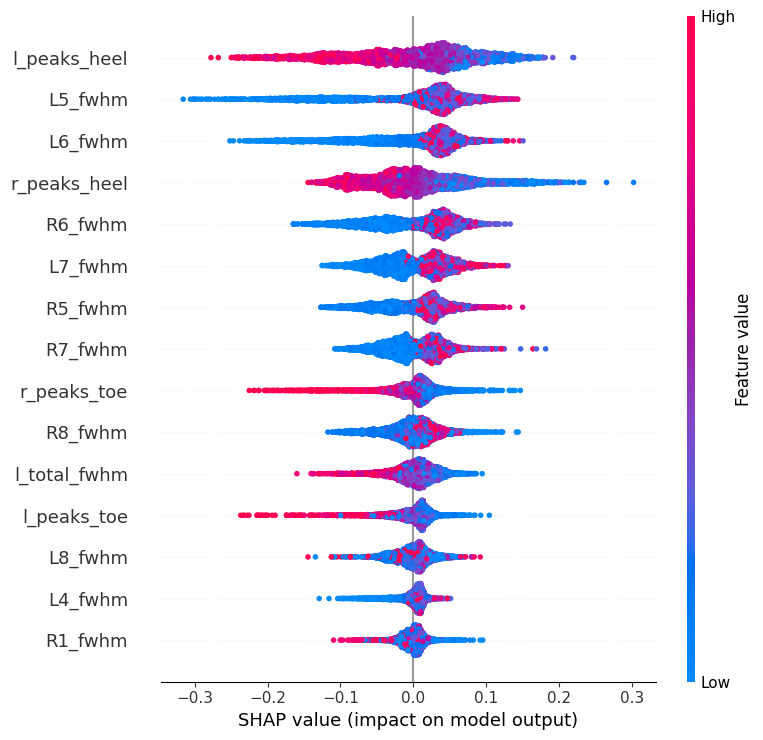

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(ccs[3])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_val_selected)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_val_selected,feature_names=selected_features)